# Load Dataset


In [117]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Layer, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization, Reshape, Conv2DTranspose, Dropout, LeakyReLU, Flatten
import time
from IPython import display
from tqdm import tqdm
import datetime

In [118]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [119]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train = int(len(images)*0.8)
train_images = images[:train]
# You should also define a samller subset of the images for testing..
# TODO
test_images = images[train:]
print(len(test_images))
print(len(train_images))
# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on
28309
113236


In [120]:
# define shuffle and batching sizes
batch_size = 128
shuffle_size = 10000
prefetch_size = 8

In [121]:
def preprocess(data):
    # change dtype of images
    data = data.map(lambda img: tf.cast(img, tf.float32))
    # change value range from 0-255 to -1 - 1
    data = data.map(lambda img: (img/128)-1)
    # change format/shape to 28,28,1
    data = data.map(lambda img: tf.reshape(img, (28,28,1)))

    # do other prepocessing stuff
    data = data.shuffle(shuffle_size).batch(batch_size).prefetch(prefetch_size)
    return data




# Data Pipeline


In [122]:
# create datasets from tensor
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)


# preprocess datasets
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)


# Discriminator 

In [124]:
class Discriminator2(Model):
    def __init__(self):
        super(Discriminator2, self).__init__()

        self.optimizer = tf.keras.optimizers.Adam()

        self.loss_function = tf.keras.losses.BinaryCrossentropy()
        
        self.input_layer = tf.keras.Input(shape=(28,28,1))
        
        self.l = [
            Conv2D(32, kernel_size=3, strides=2, padding='same'),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.2),

            Conv2D(32, kernel_size=3, strides=2, padding='same'),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.2),
            Flatten(),
            Dense(units=1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.01))
        ]
        self.out = self.call(self.input_layer, training=True)


    def call(self, x, training=False):
        for layer in self.l:
            try:
                x = layer(x, training=training)
            except:
                x = layer(x)
        
        return x

# Generator Class


In [126]:
class Generator2(Model):
    def __init__(self):
        super(Generator2, self).__init__()
        
        self.optimizer = tf.keras.optimizers.Adam()

        self.loss_function = tf.keras.losses.BinaryCrossentropy()
        
        self.input_layer = tf.keras.layers.Input(shape=(100))
        self.l = [
            Dense(units=7*7*128, use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            BatchNormalization(),
            LeakyReLU(),

            Reshape(target_shape=(7, 7, 128)),

            Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.2),

            Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.2),

            Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01))
        ]
        self.out = self.call(self.input_layer, training=True)


    def call(self, x, training):
        for layer in self.l:
            try:
                x = layer(x, training)
            except:
                x = layer(x)
        
        return x

In [133]:
#test the Generator
G_Test = Generator()
x = tf.random.normal([batch_size,49])
x = G_Test(x)
print(x)

tf.Tensor(
[[[[ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  ...

  [[ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]]


 [[[ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   ...
   [ 5.03873173e-03]
   [-5.35156904e-03]
   [ 6.29902491e-03]]

  [[ 0.00000000e+00]
   [ 0.0000000

In [129]:
# maybe seperate test function
def test(D, G, data, noise):

    test_loss_aggregator_d = []
    test_loss_aggregator_g = []
    
    for d in data:
        # process data and get predictions
        fake_data = G(noise)
        fake_data_pred = D(fake_data)
        real_data_pred = D(d)
        # compute loss for both networks
        D_loss = -tf.math.reduce_mean( tf.math.log(real_data_pred) + tf.math.log(1-fake_data_pred) )    
        G_loss = tf.math.reduce_mean( tf.math.log(1-fake_data_pred) )
        # append losses to array 
        test_loss_aggregator_d.append(D_loss)
        test_loss_aggregator_g.append(G_loss)
    #compute loss mean for 
    D_loss = tf.reduce_mean(test_loss_aggregator_d)
    G_loss = tf.reduce_mean(test_loss_aggregator_g)

    return D_loss, G_loss


In [130]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Firing up Generator and Discriminator


100%|██████████| 885/885 [01:33<00:00,  9.42it/s]


<Figure size 1440x720 with 0 Axes>

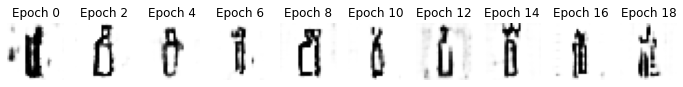

In [131]:
# clear session
tf.keras.backend.clear_session()
# define hyperparameters
num_epochs = 20
latent_space_size = 100
# create empty arrays and lists 
test_losses = []
images_generated = []

# create instances of Generator and Discriminator
G = Generator2()
D = Discriminator2()


#tensorboard setup
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_path = f"./logs/wgan/train" + time
test_path = f"./logs/wgan/test" + time
train_summary_writer = tf.summary.create_file_writer(train_path)
test_summary_writer = tf.summary.create_file_writer(test_path)


#accuracy metrics
acc = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
generated_images = []

# Entry print
print("Firing up Generator and Discriminator")

# loop through epochs
for epoch in range(num_epochs):       
    gen_loss = []
    disc_loss = []     
    loss_epoch_gen = []
    loss_epoch_dis = []
    acc_aggregator = []

    for data in tqdm(train_ds):
        #create random noise
        noise = tf.random.normal([batch_size,latent_space_size])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                
            gen_images = G(noise, training=True)
            
            # discriminator's output for both fake and real images
            real_output = D(data, training=True)
            fake_output = D(gen_images, training=True)

            # loss functions for generator and discriminator, including the L2 regularization term
            gen_loss = G.loss_function(tf.ones_like(fake_output), fake_output) + tf.reduce_sum(G.losses)
            disc_loss = D.loss_function(tf.ones_like(real_output), real_output) + D.loss_function(tf.zeros_like(fake_output), fake_output) + tf.reduce_sum(D.losses)

            # computation of accuracy
            labels = tf.concat((tf.ones_like(real_output), tf.zeros_like(fake_output)), axis=0)
            images = tf.concat((real_output, fake_output), axis=0)
            acc_aggregator.append(acc(labels, images))

        gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, D.trainable_variables)
            
        G.optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
        D.optimizer.apply_gradients(zip(disc_gradients, D.trainable_variables))

    # create 1 image using the Generator per epoch and add for later visualization
    im = G(tf.random.normal(shape=(1,100)))
    generated_images.append(im)

    aggregated_acc = tf.reduce_mean(acc_aggregator)
    
    with train_summary_writer.as_default():
            tf.summary.scalar(name="gen loss", data=gen_loss, step=epoch)
            tf.summary.scalar(name="disc loss", data=disc_loss, step=epoch)
            tf.summary.scalar(name="disc acc", data=aggregated_acc, step=epoch)
            tf.summary.image(name="gen_image", data=im, step=epoch)

    for image_batch in test_ds:

        test_output = D(image_batch)
        test_labels = tf.ones_like(test_output)
        
        # measure accuracy on test set
        test_acc = tf.reduce_mean(acc(test_labels, test_output))
        
        with test_summary_writer.as_default():
            tf.summary.scalar(name="test_acc", data=test_acc, step=epoch)


# visualize produced images
ncols = int(num_epochs / 10)
fig = plt.figure(figsize=(12, 12), tight_layout=False)
for i in range(0, len(generated_images), ncols):
    plt.subplot(1, int(len(generated_images)/ncols), 1 if i==0 else int((i/ncols)+1), title=f"Epoch {i}")
    plt.imshow(generated_images[i][0, :, :, 0], cmap='gray_r')
    plt.axis('off')
